# Contextual linear bandit with Thompson sampling

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# Context-free multi-armed Bernoulli bandit

In [3]:
from jax.scipy.stats import beta
from jax import random
from jax.nn import one_hot

In [4]:
def thompson_sampling_step(state, key):
    alphas, betas, probs = state
    keys = key
    K = len(alphas)
    
    # Choose an arm to pull
    # (Sample from the policy distribution)
    theta_t = random.beta(key, alphas, betas).argmax()
    # Pull the arm and observe reward (either 1 or 0)
    reward = random.bernoulli(key, probs[theta_t])
    
    # Update policy distribution
    ind_vector = one_hot(theta_t, K)
    alphas_posterior = alphas + ind_vector * reward
    betas_posterior = betas + ind_vector * (1 - reward)
    
    return (alphas_posterior, betas_posterior, probs), (alphas_posterior, betas_posterior)

In [5]:
T = 200
key = random.PRNGKey(314)
keys = random.split(key, T)
probs = jnp.array([0.65, 0.4, 0.5, 0.9])
#probs = jnp.ones(5) * 0.5
K = len(probs)


alpha_priors = jnp.ones(K) * 1
beta_priors = jnp.ones(K) * 1

init_state = (alpha_priors, beta_priors, probs)
posteriors, hist = jax.lax.scan(thompson_sampling_step, init_state, keys)
alpha_posterior, beta_posterior, _ = posteriors
alpha_hist, beta_hist = hist

alpha_posterior, beta_posterior

(DeviceArray([  8.,   9.,  18., 140.], dtype=float32),
 DeviceArray([ 4.,  7., 11., 11.], dtype=float32))

In [6]:
p_range = jnp.linspace(0, 1, 100)
bandits_pdf_hist = beta.pdf(p_range[:, None, None], alpha_hist[None, ...], beta_hist[None, ...])

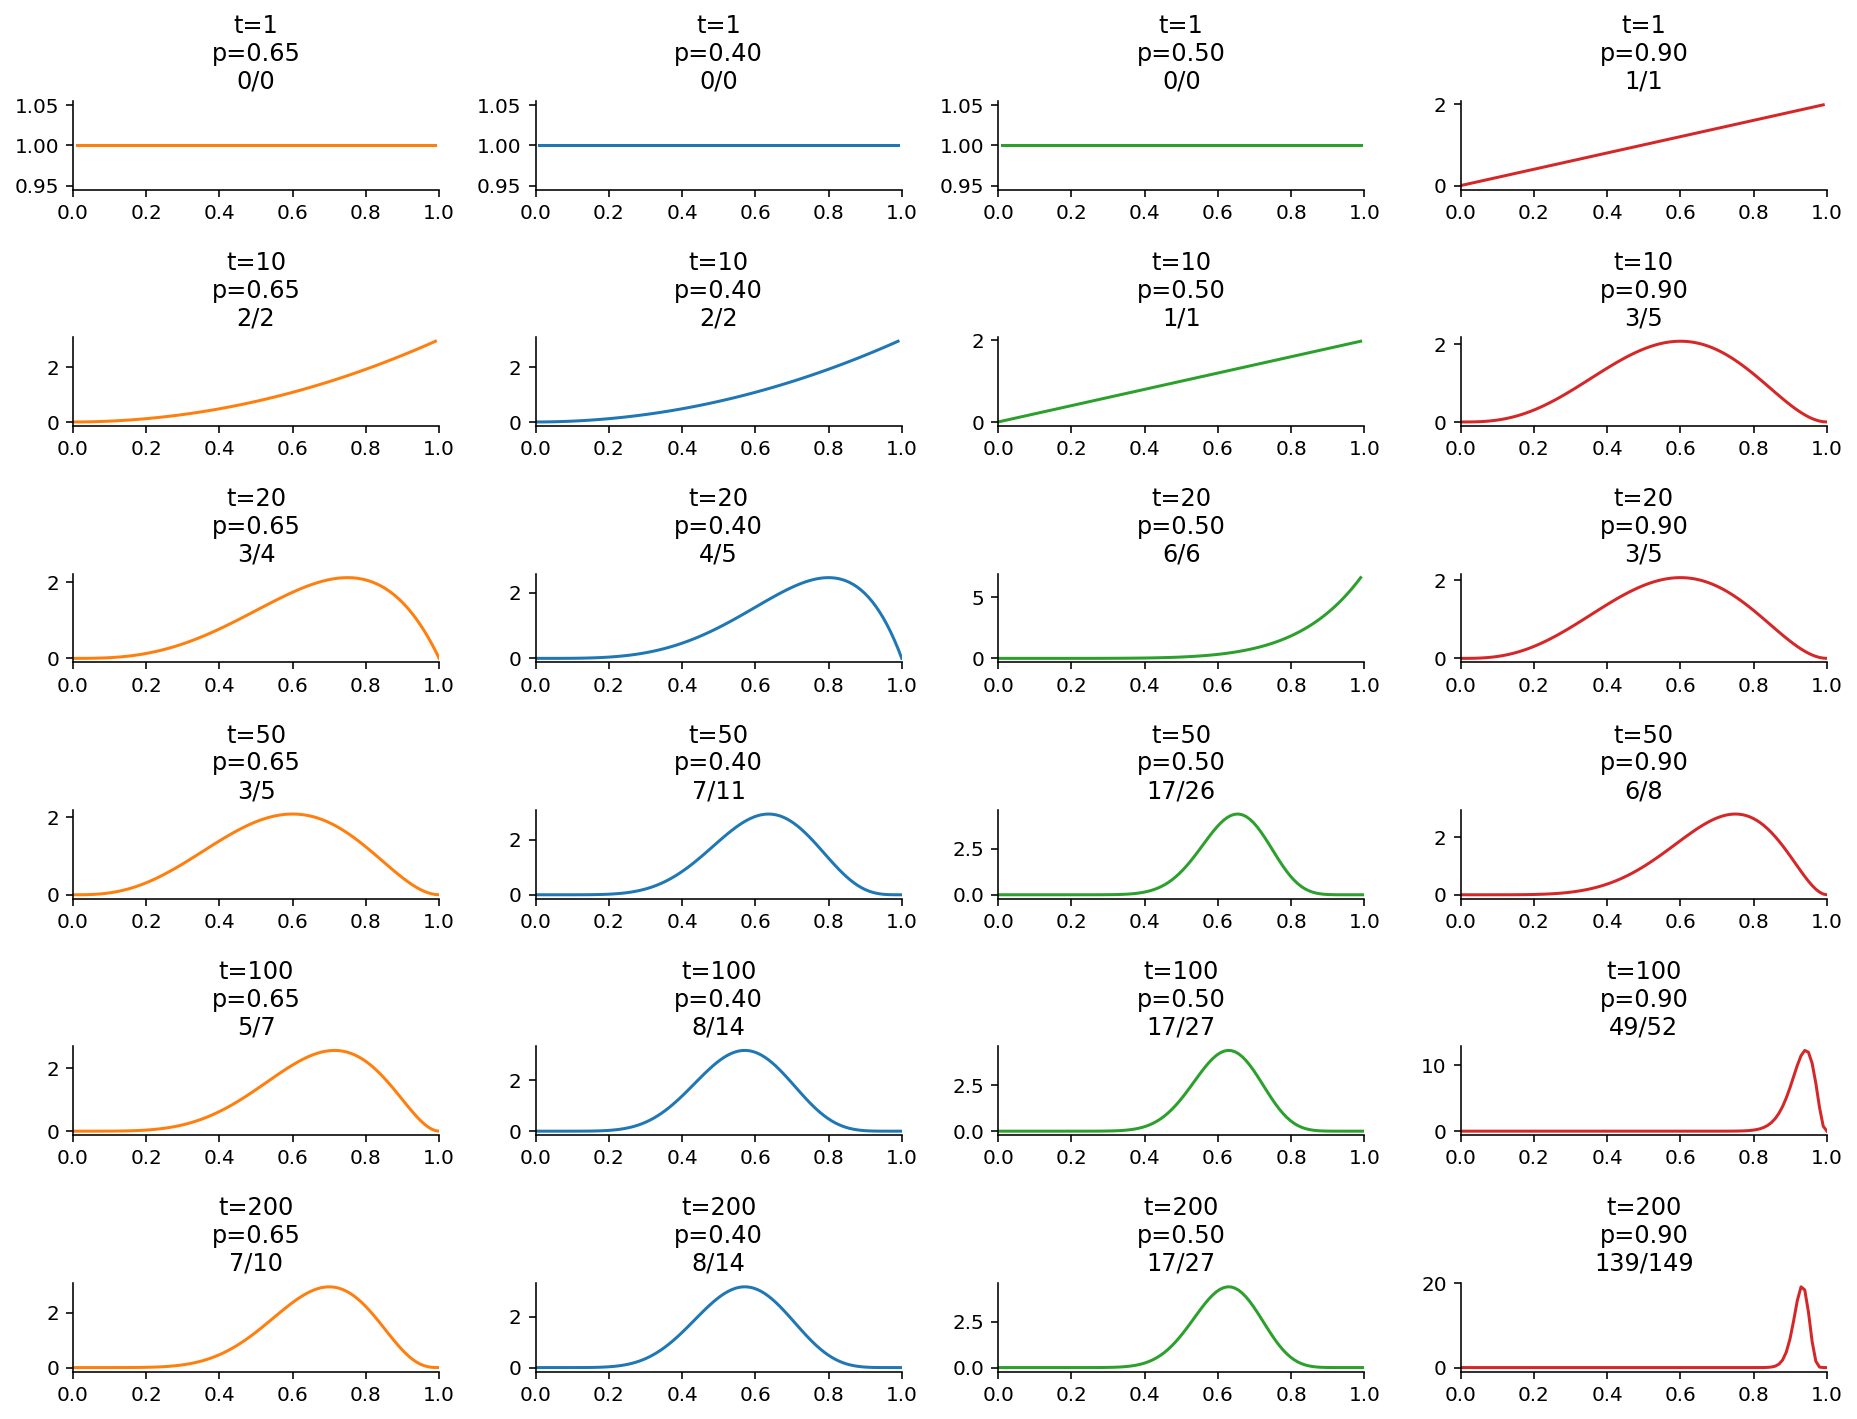

In [7]:
colors = ["orange", "blue", "green", "red"]
colors = [f"tab:{color}" for color in colors]
# Indexed by position
times = [0, 9, 19, 49, 99, 199]

fig, ax = plt.subplots(len(times), K, figsize=(13, 10))
for ax_row, t in zip(ax, times):
    for k, (axi, color) in enumerate(zip(ax_row, colors)):
        bandit = bandits_pdf_hist[:, t, k]
        axi.plot(p_range, bandit, c=color)
        axi.set_xlim(0, 1)
        n_pos = alpha_hist[t, k].item() - 1
        n_trials = beta_hist[t, k].item() + n_pos - 1
        axi.set_title(f"t={t+1}\np={probs[k]:0.2f}\n{n_pos:.0f}/{n_trials:.0f}")
plt.tight_layout()

## A better API

In [122]:
from functools import partial

In [115]:
class BetaBernoulliBandits:
    def __init__(self, mean_rewards):
        self.mean_rewards = mean_rewards
        self.K = len(mean_rewards)
        
    def sample(self, key, params):
        alphas = params["alpha"]
        betas = params["beta"]
        params_sample = random.beta(key, alphas, betas)
        return params_sample
    
    def predict_rewards(self, params_sample):
        return params_sample
    
    def true_reward(self, key, action):
        reward = random.bernoulli(key, self.mean_rewards[action])
        return reward
        
    def update(self, action, params, reward):
        alphas = params["alpha"]
        betas = params["beta"]
        # Update policy distribution
        ind_vector = one_hot(action, self.K)
        alphas_posterior = alphas + ind_vector * reward
        betas_posterior = betas + ind_vector * (1 - reward)
        return {
            "alpha": alphas_posterior,
            "beta": betas_posterior
        }

def thompson_sampling_step(model_params, key, model):
    key_sample, key_reward = random.split(key)
    params = model.sample(key, model_params)
    pred_rewards = model.predict_rewards(params)
    action = pred_rewards.argmax()
    reward = model.true_reward(key, action)
    model_params = model.update(action, model_params, reward)
    return model_params, model_params

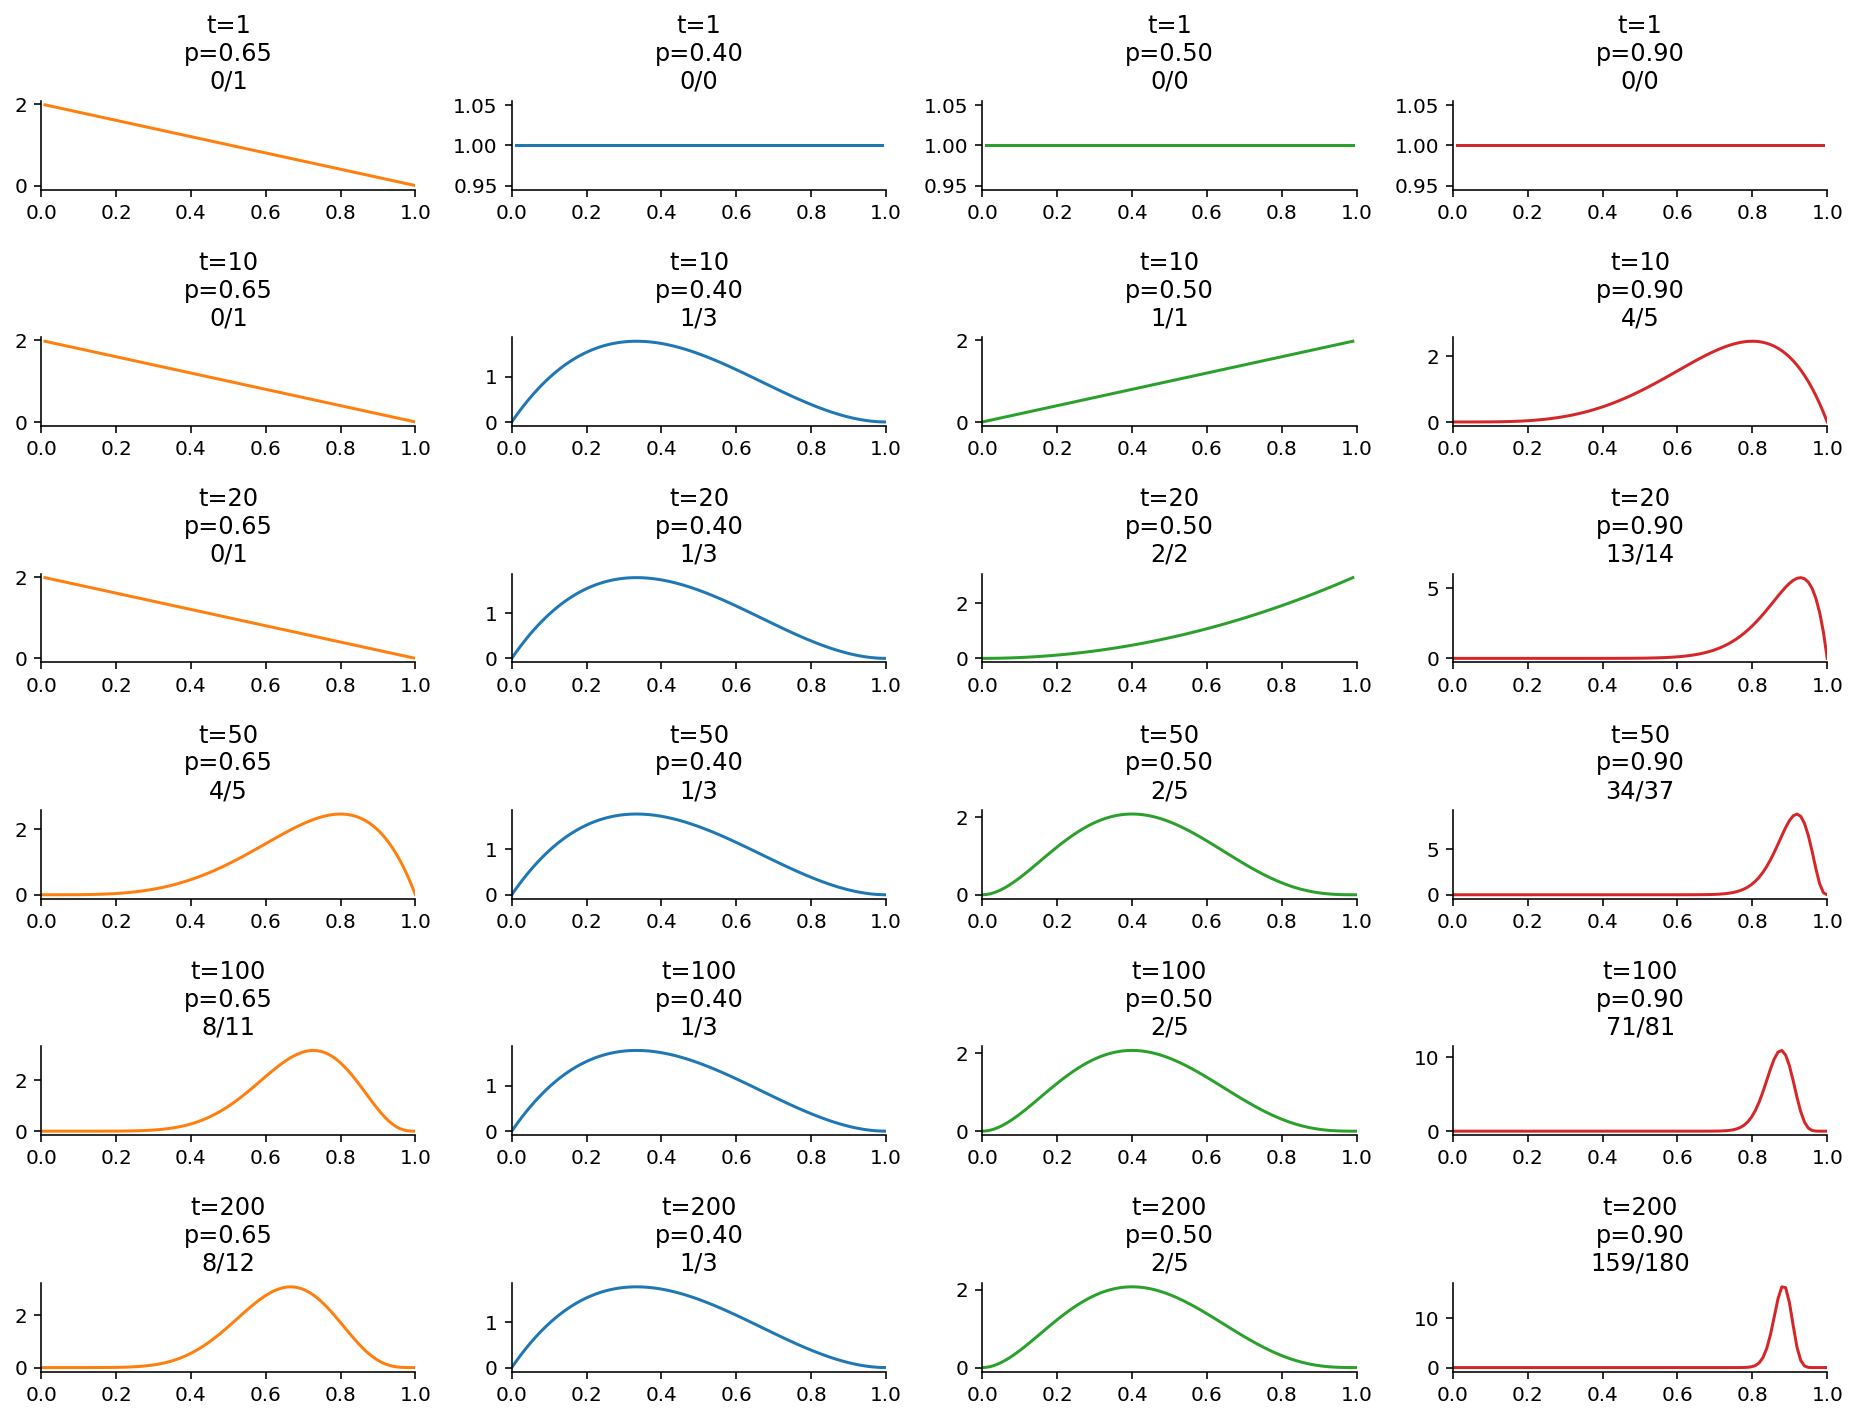

In [125]:
T = 200
key = random.PRNGKey(31415)
keys = random.split(key, T)

mean_rewards = jnp.array([0.65, 0.4, 0.5, 0.9])
bbbandit = BetaBernoulliBandits(mean_rewards)
init_params = {"alpha": jnp.ones(K),
               "beta": jnp.ones(K)}

thompson_partial = partial(thompson_sampling_step, model=BetaBernoulliBandits(mean_rewards))
posteriors, hist = jax.lax.scan(thompson_partial, init_params, keys)

p_range = jnp.linspace(0, 1, 100)
bandits_pdf_hist = beta.pdf(p_range[:, None, None], hist["alpha"][None, ...], hist["beta"][None, ...])

colors = ["orange", "blue", "green", "red"]
colors = [f"tab:{color}" for color in colors]
# Indexed by position
times = [0, 9, 19, 49, 99, 199]

fig, ax = plt.subplots(len(times), K, figsize=(13, 10))
for ax_row, t in zip(ax, times):
    for k, (axi, color) in enumerate(zip(ax_row, colors)):
        bandit = bandits_pdf_hist[:, t, k]
        axi.plot(p_range, bandit, c=color)
        axi.set_xlim(0, 1)
        n_pos = hist["alpha"][t, k].item() - 1
        n_trials = hist["beta"][t, k].item() + n_pos - 1
        axi.set_title(f"t={t+1}\np={probs[k]:0.2f}\n{n_pos:.0f}/{n_trials:.0f}")
plt.tight_layout()

# Contextual multiarmed Normal bandit
## Linear case

## References
* https://github.com/ofirnabati/Neural-Linear-Bandits-with-Likelihood-Matching